# (Optional) Check hardware for available GPU

In this section, I am using tensorflow to check for available GPUs and (if possible) set memory growth across the GPUs

In [1]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


# Library and data import

In [2]:
import pandas as pd                                     # For reading and working with tabular csv data
import tensorflow as tf                                 # General machine learning functionalities
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.utils import Sequence             # For creating data generators for training
import numpy as np
import matplotlib.pyplot as plt                         # To visualize model training process
from sklearn.model_selection import train_test_split

c:\Users\caomi\anaconda3\envs\tf\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data Discovery and Processing

In [40]:
# # Old data, which was split into feature and label files
# feature_csv_path = "data/inputs.csv"
# label_csv_path = "data/outputs.csv"

# # Load features and labels
# features_df = pd.read_csv(feature_csv_path)
# label_df = pd.read_csv(label_csv_path)

data_csv_path = "FIS/data.csv"
data_df = pd.read_csv(data_csv_path)

## Data inspection and discovery

In [ ]:
print(f"Dimension of feature dataframe: ",data_df.shape)
data_df.sample(10)

Dimension of feature dataframe:  (10000, 7)


,Load History,Distance to Task,Total Distance Travelled,Robot Type,Task Type,Capability Match?,Suitability
5379,7,17.231330,7.113004,Small,Medium,0,0.000000
4621,4,24.701103,10.274291,Medium,Medium,1,4.120670
2501,4,24.787193,12.617463,Large,Large,1,3.918281
7101,4,17.307606,28.191247,Medium,Medium,1,3.445352
6443,6,19.933647,43.974892,Medium,Medium,1,1.741485
513,2,24.088577,44.873903,Large,Large,1,2.454515
3153,8,21.701946,39.772230,Medium,Small,0,0.000000
5588,6,17.844519,0.311891,Large,Large,1,3.971764
5989,4,11.843612,16.454813,Small,Large,0,0.000000
7814,3,5.677272,10.271729,Medium,Large,0,0.000000


The capability match feature already reflects the match between robot type and task type, where capability is 1 if robot type == task type. Furthermore, these features are categorical, so they are discarded

In [62]:
feature_df = data_df.drop(columns=['Robot Type', 'Task Type','Suitability'])
INPUT_SHAPE = feature_df.shape[1]

print(f"Dimension of label dataframe: ",feature_df.shape)
feature_df.head(10)

Dimension of label dataframe:  (10000, 4)


,Load History,Distance to Task,Total Distance Travelled,Capability Match?
0,9,20.540772,27.597702,1
1,2,10.080196,38.724002,1
2,8,8.690871,29.982843,0
3,5,9.835623,37.867265,1
4,1,0.416514,13.785328,0
5,6,22.022368,41.682977,1
6,3,21.526918,46.457266,1
7,1,10.323034,36.546152,1
8,3,9.924901,20.932862,1
9,4,4.435074,38.906418,1


In [52]:
label_df = pd.DataFrame(data_df['Suitability'])

print(f"Dimension of label dataframe: ",label_df.shape)
label_df.head(10)

Dimension of label dataframe:  (10000, 1)


,Suitability
0,2.094455
1,5.078582
2,0.000000
3,3.919463
4,0.000000
5,1.533857
6,2.571079
7,5.734623
8,5.007826
9,5.200229


## Convert dataframe to numpy arrays

In [53]:
features_array = feature_df.to_numpy()
label_array = label_df.to_numpy()

## Train-Test Split

In [55]:
# Split the training data to test set and (train+validation) set
X_train, X_test, y_train, y_test = train_test_split(features_array,
                                                    label_array,
                                                    test_size=0.2,
                                                    random_state=12)

# Split the (train + validation) set to train set and validation set
X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                  y_train,
                                                  test_size=0.2,
                                                  random_state=12)

In [56]:
print(f"There are {X_train.shape[0]} samples in the train set\n"
      f"There are {X_val.shape[0]} samples in the validation set\n"
      f"There are {X_test.shape[0]} samples in the test set")

There are 6400 samples in the train set
There are 1600 samples in the validation set
There are 2000 samples in the test set


In [63]:
class DataGenerator(Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch_x, batch_y
    
BATCH_SIZE = 32

# These generator objects will generate BATCH_SIZE samples at a time from the specified nparray
train_gen = DataGenerator(X_train,y_train,BATCH_SIZE)
val_gen = DataGenerator(X_val,y_val,BATCH_SIZE)
test_gen = DataGenerator(X_test,y_test,BATCH_SIZE)

# Model Construction

In [83]:
def build_model(layer_widths, input_shape, activation='relu', learning_rate=0.001):
    """
    Creates a Keras Sequential model based on the specified architecture.

    Args:
        layer_widths (list): A list where each element is the number of nodes in a layer.
        input_shape (tuple): Shape of the input data (e.g., (num_features,)).
        activation (str): Activation function to use in the hidden layers.
        learning_rate (float): Learning rate for the optimizer.

    Returns:
        model (Sequential): A compiled Keras Sequential model.
    """
    model = keras.Sequential()

    # Add additional hidden layers based on layer_widths
    for i,width in enumerate(layer_widths):
        if i==0: 
            model.add(layers.Dense(width, activation=activation, input_shape=input_shape))
        else: 
            model.add(layers.Dense(width, activation=activation))
        model.add(layers.BatchNormalization())

    # Add the output layer (no activation for regression)
    model.add(layers.Dense(1,name = "Output_layer"))

    # Compile the model with a regression-friendly loss function
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), 
                  loss='mse', 
                  metrics=['mae',keras.metrics.RootMeanSquaredError()])
    
    return model

layer_widths = [64,32,16,1]
LEARNING_RATE = 0.001
EPOCH = 50
tf.keras.backend.clear_session()
model = build_model(layer_widths = layer_widths,
                    input_shape= (INPUT_SHAPE,),
                    learning_rate=LEARNING_RATE)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                320       
                                                                 
 batch_normalization (BatchN  (None, 64)               256       
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 batch_normalization_1 (Batc  (None, 32)               128       
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 batch_normalization_2 (Batc  (None, 16)               6

# Model Training and Training Visualization

In [84]:
history = model.fit(train_gen,
                    batch_size=BATCH_SIZE,
                    validation_data=val_gen,
                    epochs = EPOCH)

Epoch 1/50
200/200 [==============================] - 2s 8ms/step - loss: 10.0862 - mae: 2.7482 - root_mean_squared_error: 3.1759 - val_loss: 12.9259 - val_mae: 3.0978 - val_root_mean_squared_error: 3.5953
Epoch 2/50
200/200 [==============================] - 1s 7ms/step - loss: 5.9941 - mae: 2.2004 - root_mean_squared_error: 2.4483 - val_loss: 6.6701 - val_mae: 2.3504 - val_root_mean_squared_error: 2.5827
Epoch 3/50
200/200 [==============================] - 1s 7ms/step - loss: 3.5006 - mae: 1.6963 - root_mean_squared_error: 1.8710 - val_loss: 2.4559 - val_mae: 1.4272 - val_root_mean_squared_error: 1.5671
Epoch 4/50
200/200 [==============================] - 1s 7ms/step - loss: 1.9955 - mae: 1.2439 - root_mean_squared_error: 1.4126 - val_loss: 1.9214 - val_mae: 1.3017 - val_root_mean_squared_error: 1.3862
Epoch 5/50
200/200 [==============================] - 1s 7ms/step - loss: 1.0961 - mae: 0.8744 - root_mean_squared_error: 1.0469 - val_loss: 0.6144 - val_mae: 0.6635 - val_root_mean_

In [85]:
def plot_performance(history, learning_rate=None, batch_size=None, finetune_epochs=None):
    # Determine whether history is keras history or a dictionary to appropriately extract the history data
    if isinstance(history, keras.callbacks.History):
        history_data = history.history        # Extract the history dictionary
    else:
        history_data = history                # Assume it's already a dictionary

    metric_list = list(history_data.keys())     # Extract the list of history keys
    half_length = len(metric_list) // 2         # The index where the validation metrics start

    metric2txt_dict = {'mae': "Mean Absolute Error",
                       'root_mean_squared_error': "Root Mean Square Error",
                       'loss': 'Loss'}

    plt.figure(figsize=(half_length * 5,5))

    for index, metric in enumerate(metric_list[:half_length]):
        metric_train = metric
        metric_val = metric_list[index+half_length]

        plt.subplot(1,half_length,index+1)
        ylim_acc = [0, max(max(history_data[metric_train]),max(history_data[metric_val]))]
        plt.plot(history_data[metric_train], label = metric_train)
        plt.plot(history_data[metric_val], label = metric_val)
        plt.ylim(ylim_acc)
        # plt.ylabel(metric_train)
        plt.xlabel('Epoch')
        plt.legend(loc='upper right')
        if learning_rate and batch_size:
            plt.title(f'{metric2txt_dict[metric_train]} \n lr = {learning_rate}, batch size = {batch_size}')
        else: plt.title(f'{metric2txt_dict[metric_train]}')

        plt.grid(which='major', color='black', linestyle='--', linewidth=0.5)

        # Enable the minor grid
        plt.minorticks_on()  # Turn on the minor ticks
        plt.grid(which='minor', color='gray', linestyle=':', linewidth=0.5)


    return metric_list

['loss',
 'mae',
 'root_mean_squared_error',
 'val_loss',
 'val_mae',
 'val_root_mean_squared_error']

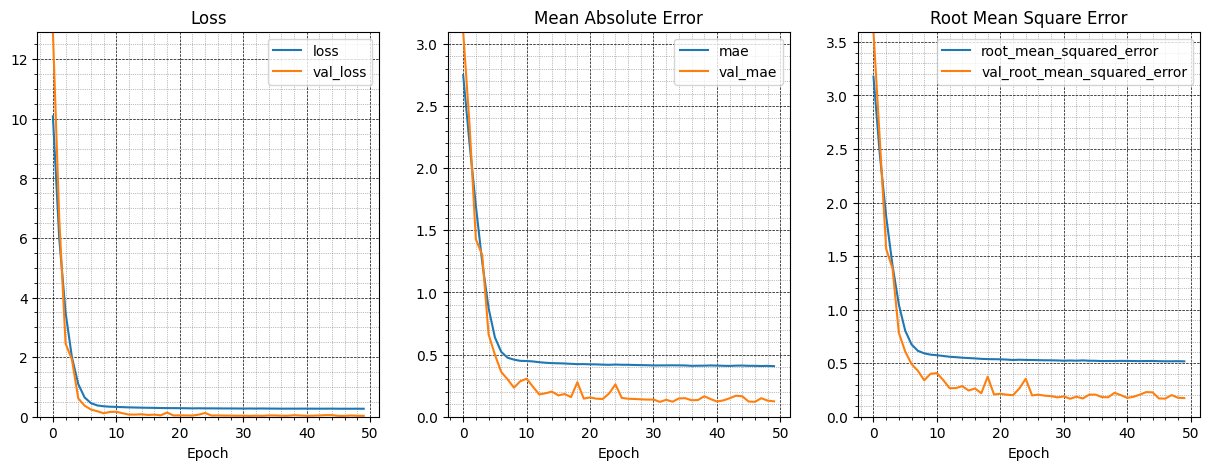

In [86]:
plot_performance(history)

# Model Prediction

In [87]:
model.evaluate(test_gen)

63/63 [==============================] - 0s 3ms/step - loss: 0.0292 - mae: 0.1202 - root_mean_squared_error: 0.1709


[0.029214782640337944, 0.12022377550601959, 0.17092332243919373]

In [88]:
y_pred = model.predict(X_test)

63/63 [==============================] - 0s 2ms/step


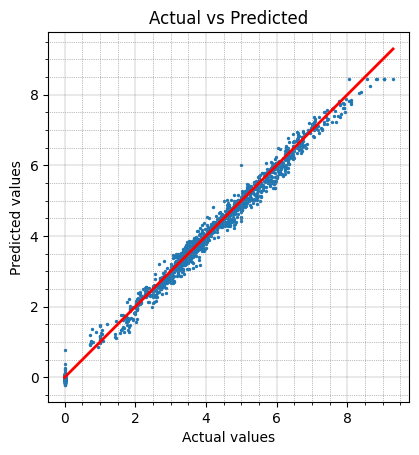

In [89]:
# Scatter plot of actual vs predicted values
plt.scatter(y_test, y_pred,s=2)

# Line showing perfect prediction (if predicted = actual)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', lw=2)
plt.gca().set_aspect('equal', adjustable='box')

plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.title('Actual vs Predicted')

plt.grid(which='major', color='gray', linestyle='-', linewidth=0.25)
plt.grid(which='minor', color='gray', linestyle=':', linewidth=0.5)
plt.minorticks_on()

plt.show()

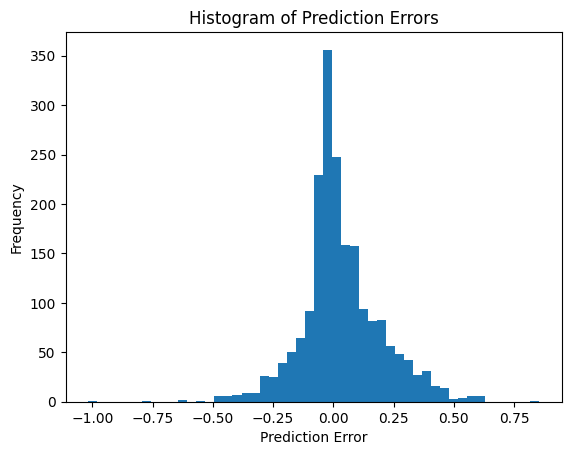

In [90]:
errors = y_test - y_pred
plt.hist(errors, bins=50)
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.title('Histogram of Prediction Errors')
plt.show()

# Save the Model

In [91]:
model_directory = 'model/model.h5'

# Save the model in HDF5 format
model.save(model_directory)

# Load the Model

In this section, I will load the saved .h5 model and retest it on the testset. The regression results should be identical to the results in the Model Prediction section

In [96]:
from tensorflow.keras.models import load_model

loaded_model = load_model(model_directory)

In [97]:
y_loaded_pred = loaded_model.predict(X_test)

63/63 [==============================] - 0s 2ms/step


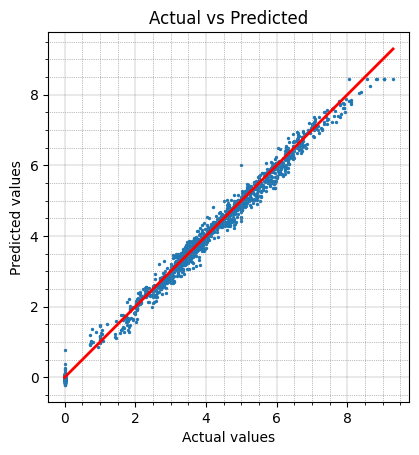

In [98]:
# Scatter plot of actual vs predicted values
plt.scatter(y_test, y_loaded_pred,s=2)

# Line showing perfect prediction (if predicted = actual)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', lw=2)
plt.gca().set_aspect('equal', adjustable='box')

plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.title('Actual vs Predicted')

plt.grid(which='major', color='gray', linestyle='-', linewidth=0.25)
plt.grid(which='minor', color='gray', linestyle=':', linewidth=0.5)
plt.minorticks_on()

plt.show()

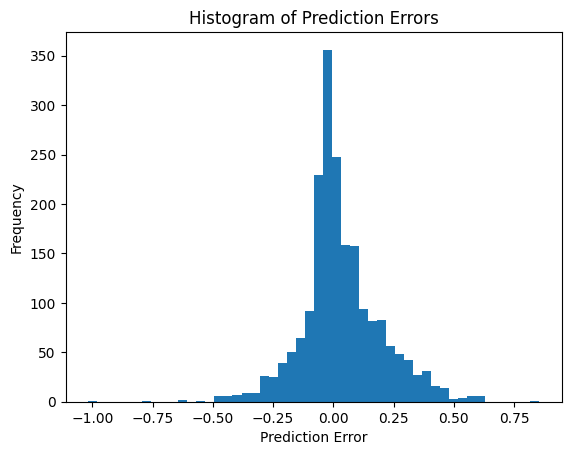

In [99]:
errors = y_test - y_loaded_pred
plt.hist(errors, bins=50)
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.title('Histogram of Prediction Errors')
plt.show()